In [1]:
"""
Created on August 31 2022
    
@author: JJ
"""

'\nCreated on August 31 2022\n\n@author: JJ\n'

In [2]:
import os, re, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pandas as pd
from math import log
import random
import scipy.io
import tensorflow as tf
import csv

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [5]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6400)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [8]:
#import from python files
from model import build_model

In [9]:
# in a well-defined initial state.
random.seed(1337)
np.random.seed(1337)
tf.random.set_seed(1337)

In [10]:
import matplotlib
import matplotlib.pyplot as plt

In [11]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
from collections import defaultdict

In [13]:
all_pep, all_mhc, all_target = np.load('all_pep.npy'), np.load('all_mhc.npy'), np.load('all_target.npy')

In [14]:
from dataclasses import replace


def balanced_sampling(pep, mhc, target):
    pos = np.where(target==1)
    neg = np.where(target==0)

    pep_pos, mhc_pos, target_pos = pep[pos], mhc[pos], target[pos]
    pep_neg, mhc_neg, target_neg = pep[neg], mhc[neg], target[neg]

    pep_pos, mhc_pos, target_pos = resample(pep_pos, mhc_pos, target_pos, n_samples= len(target_pos), replace = False)
    pep_neg, mhc_neg, target_neg = resample(pep_neg, mhc_neg, target_neg, n_samples= len(target_pos), replace = False)


    pep = np.concatenate([pep_pos, pep_neg])
    mhc = np.concatenate([mhc_pos, mhc_neg])
    target = np.concatenate([target_pos, target_neg])

    pep, mhc, target = shuffle(pep, mhc, target)
    return pep, mhc, target
    

In [15]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(all_pep, all_mhc, all_target, test_size = 0.2, stratify= all_target)

In [16]:
print(train_pep.shape)
print(test_pep.shape)

(756875, 30, 20)
(189219, 30, 20)


In [17]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [18]:
folder = 'model/Ensemble/'

In [19]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 5)

In [20]:
import gc
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        gc.collect()
        tf.keras.backend.clear_session()


In [21]:
for u in range(10):
        pep_bal, mhc_bal, target_bal = balanced_sampling(train_pep, train_mhc, train_target)
        folder = 'model/Ensemble/CV_'+str(u)+'/'
        for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
                training_pep = train_pep[train]
                training_mhc = train_mhc[train]
                training_target = train_target[train]
                
                validation_pep = train_pep[test]
                validation_mhc = train_mhc[test]
                validation_target = train_target[test]

                mc = ModelCheckpoint(folder+'model_' +str(i)+'.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

                if i == 0: 
                        model = build_model(training_pep, training_mhc)
                #model.summary()

                model.fit([training_pep,training_mhc], 
                        training_target,
                        batch_size=512,
                        epochs = 100,
                        shuffle=True,
                        callbacks=[es, mc],
                        validation_data=([validation_pep,validation_mhc], validation_target),
                        verbose=1)  
                        
                del model
                gc.collect()
                tf.keras.backend.clear_session()

        gc.collect()
        tf.keras.backend.clear_session()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
peptide (InputLayer)            [(None, 30, 20)]     0                                            
__________________________________________________________________________________________________
mhc (InputLayer)                [(None, 34, 20)]     0                                            
__________________________________________________________________________________________________
conv1_pep (Conv1D)              (None, 30, 128)      7808        peptide[0][0]                    
__________________________________________________________________________________________________
conv1_mhc (Conv1D)              (None, 34, 128)      7808        mhc[0][0]                        
______________________________________________________________________________________________

4731/4731 [==============================] - 9s 2ms/step


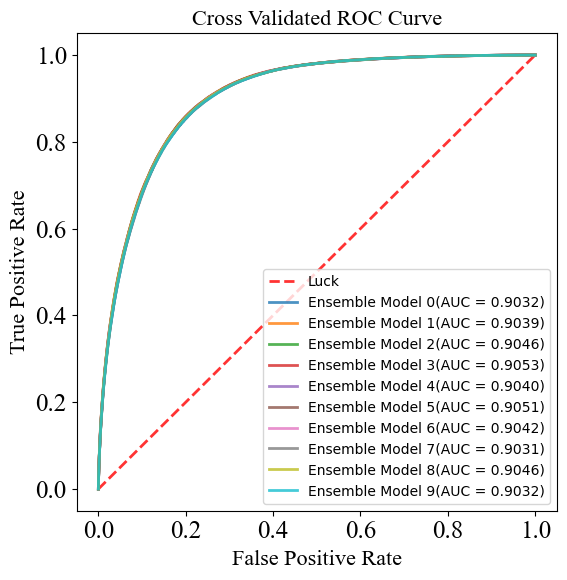

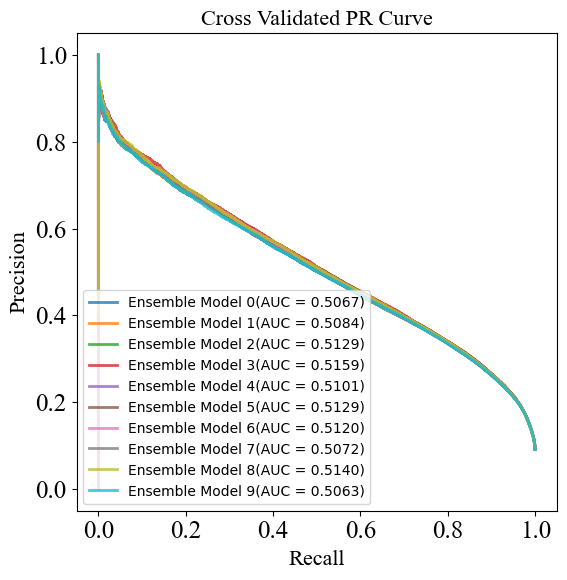

In [22]:
temp_probas=np.array([]) 
temp_labels=np.array([])

font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for u in range(10):
    pep_bal, mhc_bal, target_bal = balanced_sampling(train_pep, train_mhc, train_target)
    folder = 'model/Ensemble/CV_'+str(u)+'/'
    for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
        training_pep = train_pep[train]
        training_mhc = train_mhc[train]
        training_target = train_target[train]
        
        validation_pep = train_pep[test]
        validation_mhc = train_mhc[test]
        validation_target = train_target[test]

        savedmodel = build_model(training_pep, training_mhc)
        savedmodel.load_weights(folder+'model_'+str(i)+'.h5')
        probas_ = savedmodel.predict([np.array(validation_pep),np.array(validation_mhc)], verbose = 1)
        del savedmodel
        gc.collect()
        tf.keras.backend.clear_session()
        temp_probas = np.append(temp_probas, probas_)
        temp_labels = np.append(temp_labels, validation_target)

    if u == 0:
        fpr, tpr, threshold = roc_curve(temp_labels, temp_probas)
        auroc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(temp_labels, temp_probas)
        aupr = average_precision_score(temp_labels, temp_probas)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % (auroc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(rc, pr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")
    else:
        fpr, tpr, threshold = roc_curve(temp_labels, temp_probas)
        auroc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(temp_labels, temp_probas)
        aupr = average_precision_score(temp_labels, temp_probas)

        ax1.plot(fpr, tpr,
        label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % (auroc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(rc, pr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)
        ax2.legend(loc='lower left')

    allprobas_ = np.append(allprobas_, temp_probas)
    all_labels = np.append(all_labels, temp_labels)

    temp_probas = np.array([])
    temp_labels = np.array([])
    gc.collect()
    tf.keras.backend.clear_session()

0.9040877186873335


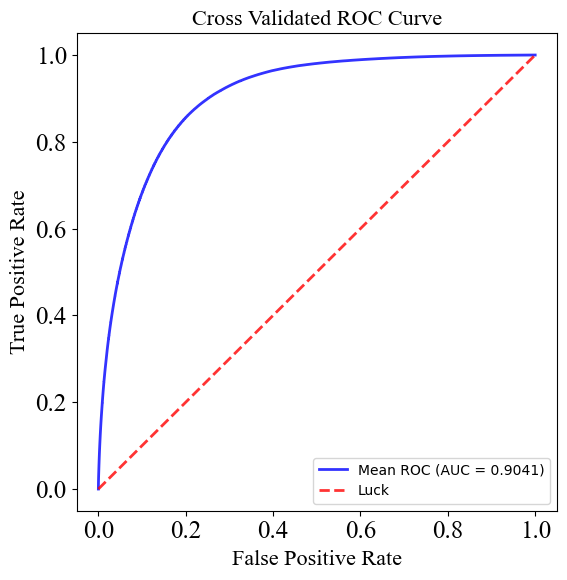

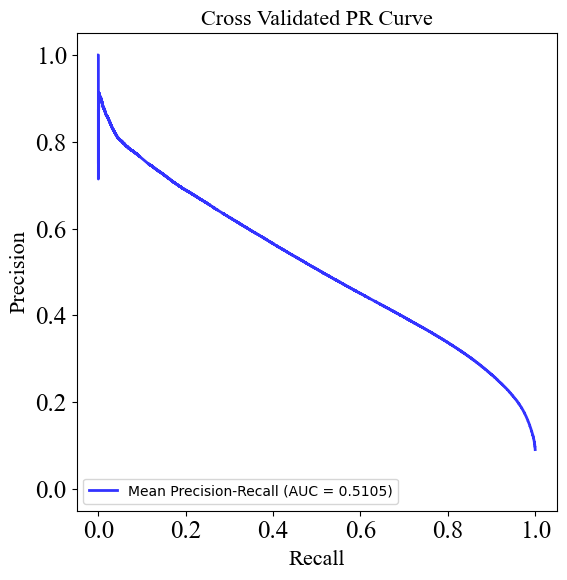

In [23]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
#figure1.savefig('figures/balancedCV_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels, allprobas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
#figure2.savefig('figures/balancedCV_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')

1183/1183 [==============================] - 2s 2ms/step


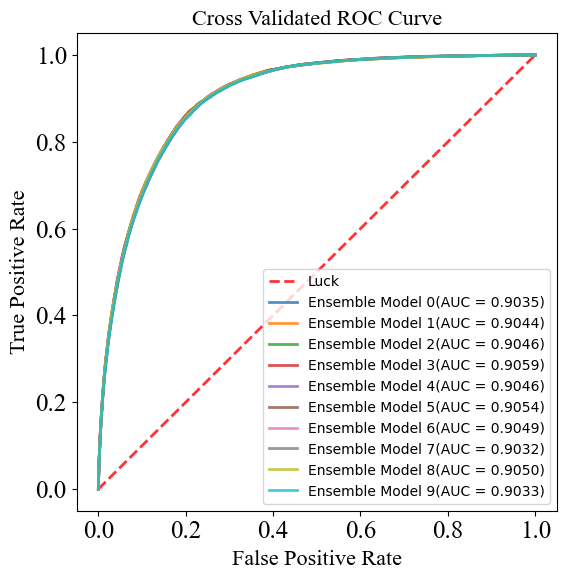

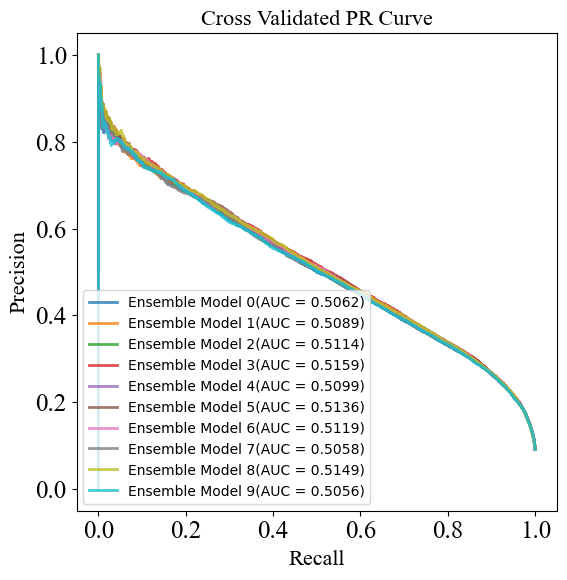

In [24]:
temp_probas2=np.array([])
temp_labels2=np.array([])
allprobas2_=np.array([]) 
all_labels2=np.array([])

font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for u in range(10):
    pep_bal, mhc_bal, target_bal = balanced_sampling(test_pep, test_mhc, test_target)
    folder = 'model/Ensemble/CV_'+str(u)+'/'
    for i, (train, test) in enumerate(kfold.split(test_pep, test_target)):
        training_pep = test_pep[train]
        training_mhc = test_mhc[train]
        training_target = test_target[train]
        
        validation_pep = test_pep[test]
        validation_mhc = test_mhc[test]
        validation_target = test_target[test]

        savedmodel = build_model(test_pep, test_mhc)
        savedmodel.load_weights(folder+'model_'+str(i)+'.h5')
        probas_ = savedmodel.predict([np.array(validation_pep),np.array(validation_mhc)], verbose = 1)
        del savedmodel
        gc.collect()
        tf.keras.backend.clear_session()
        temp_probas2 = np.append(temp_probas2, probas_)
        temp_labels2 = np.append(temp_labels2, validation_target)

    if u == 0:
        fpr, tpr, threshold = roc_curve(temp_labels2, temp_probas2)
        auroc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(temp_labels2, temp_probas2)
        aupr = average_precision_score(temp_labels2, temp_probas2)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % (auroc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(rc, pr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")
    else:
        fpr, tpr, threshold = roc_curve(temp_labels2, temp_probas2)
        auroc = auc(fpr, tpr)
        pr, rc, _ = precision_recall_curve(temp_labels2, temp_probas2)
        aupr = average_precision_score(temp_labels2, temp_probas2)

        ax1.plot(fpr, tpr,
        label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % (auroc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(rc, pr,
                label=r'Ensemble Model '+str(u)+ '(AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)
        ax2.legend(loc='lower left')

    allprobas2_ = np.append(allprobas2_, temp_probas2)
    all_labels2 = np.append(all_labels2, temp_labels2)

    temp_probas2 = np.array([])
    temp_labels2 = np.array([])
    gc.collect()
    tf.keras.backend.clear_session()

0.9044304671302944


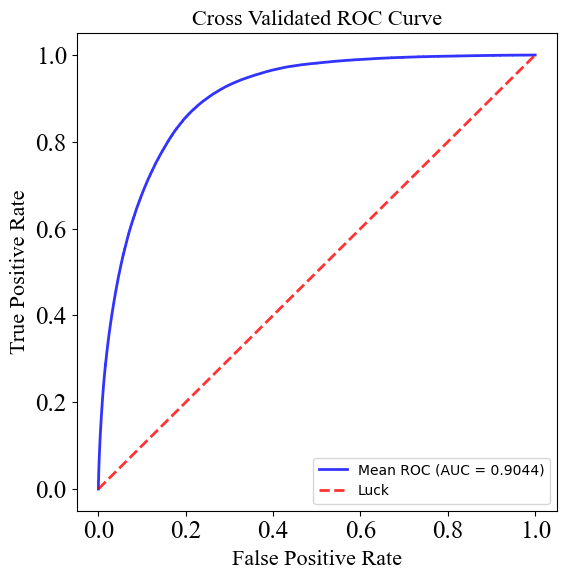

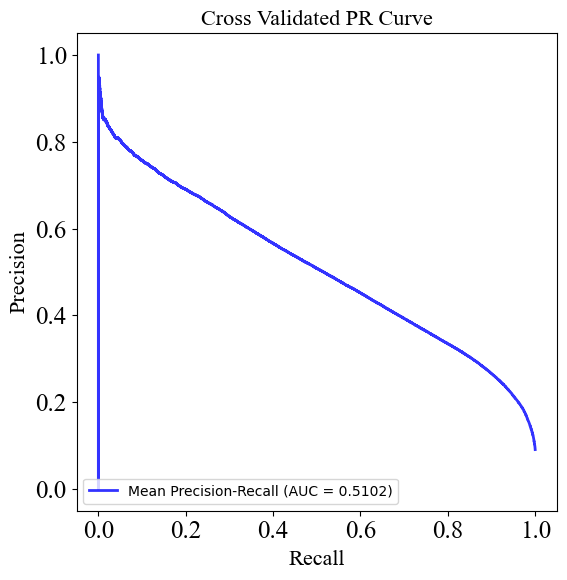

In [25]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
#figure1.savefig('figures/balancedCV_test_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels2, allprobas2_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
#figure2.savefig('figures/balancedCV_test_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')